In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import cv2
import random

import torch.autograd
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import *
import torch.nn.functional as F
import pandas

In [2]:
#用于返回有效的图片路径数据集
image_types = (".jpg",".jpeg",".png",".bmp",".tif",".tiff")
def list_images(basePath,contains = None):
    return list_files(basePath,validExts = image_types,contains = contains)
def list_files(basePath,validExts = None,contains = None):
    for(rootDir,dirNames,filenames) in os.walk(basePath):
        for filename in filenames:
            if contains is not None and filename.find(contains) == -1:
                continue
            ext = filename[filename.rfind("."):].lower()
            if validExts is None or ext.endswith(validExts):
                imagePath = os.path.join(rootDir,filename)
                yield imagePath

In [3]:
#图片数据集
class ImgDataset(Dataset):
    def __init__(self,path, transform=None):
        print("------开始读取数据------")
        self.transform = transform
        self.data = []
        self.labels = []       
        imagePaths = list(list_images(path))
        for imagePath in imagePaths:
            image = cv2.imread(imagePath)
            self.data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            self.labels.append(label)
        print("------读取文件结束------")
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = torch.Tensor(3,64,64)
        img[0,:,:] = torch.Tensor(self.data[idx][:,:,0] / 255 - 0.5)
        img[1,:,:] = torch.Tensor(self.data[idx][:,:,1] / 255 - 0.5)
        img[2,:,:] = torch.Tensor(self.data[idx][:,:,2] / 255 - 0.5)
        label = (int)(self.labels[idx])
        if self.transform:
            img = self.transform(img)
        return img,label

In [4]:
#恒等块
class IdentityBlock(nn.Module):
    def __init__(self, in_channel, out_channels,f):
        super(IdentityBlock, self).__init__()
        
        O1,O2,O3 = out_channels

        self.block = nn.Sequential(
            nn.Conv2d(in_channel, O1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(O1),
            nn.ReLU(inplace=True),
            nn.Conv2d(O1, O2, kernel_size=f,stride = 1, padding=1, bias=False),
            nn.BatchNorm2d(O2),
            nn.ReLU(inplace=True),
            nn.Conv2d(O2, O3,kernel_size=1,stride = 1,padding=0, bias = False),
            nn.BatchNorm2d(O3),
        )
    def forward(self, x):
        shortcutOut = x.clone()
        out = self.block(x)
        return F.relu(out + shortcutOut)
  
#卷积块
class ConvolutionalBlock(nn.Module):
    def __init__(self, in_channel, out_channels,f, strides=2):
        super(ConvolutionalBlock, self).__init__()
        
        O1,O2,O3 = out_channels

        self.strides = strides
        self.mainpath = nn.Sequential(
            nn.Conv2d(in_channel, O1, kernel_size=1, stride=strides, padding=1, bias=False),
            nn.BatchNorm2d(O1),
            nn.ReLU(inplace=True),
            nn.Conv2d(O1, O2, kernel_size=f,stride = 1, padding=1, bias=False),
            nn.BatchNorm2d(O2),
            nn.ReLU(inplace=True),
            nn.Conv2d(O2, O3,kernel_size=1,stride = 1,padding=0, bias = False),
            nn.BatchNorm2d(O3),
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channel, O3, kernel_size=1, stride=strides, padding=1, bias=False),
            nn.BatchNorm2d(O3),
        )
    def forward(self, x):
        shortcutIn = x.clone()
        out = self.mainpath(x)
        shortcutOut = self.shortcut(shortcutIn)
        return F.relu(out + shortcutOut)

In [5]:
#残差网络
#现存的结构已经不是ResNet50了，把全部的IdentityBlock对预测精度去掉基本没有影响
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__() 
        self.pre = nn.Sequential(
            nn.Conv2d(3,64,7,2,padding=3,bias=False),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2)
            )
        self.stage1 = nn.Sequential(
            ConvolutionalBlock(64,[64,64,256],3,strides=1),
            #IdentityBlock(256,[64,64,256],3),
            #IdentityBlock(256,[64,64,256],3)
            )
        self.stage2 = nn.Sequential(
            ConvolutionalBlock(256,[128,128,512],3,strides=1),
            #IdentityBlock(512,[128,128,512],3),
            #IdentityBlock(512,[128,128,512],3),
            #IdentityBlock(512,[128,128,512],3)
            )
        self.stage3 = nn.Sequential(
            ConvolutionalBlock(512,[256,256,1024],3,strides=2),
            #IdentityBlock(1024,[256,256,1024],3),
            #IdentityBlock(1024,[256,256,1024],3),
            #IdentityBlock(1024,[256,256,1024],3),
            #IdentityBlock(1024,[256,256,1024],3),
            #IdentityBlock(1024,[256,256,1024],3),
            nn.AvgPool2d(kernel_size=2)
            )
        self.post = nn.Sequential(
            nn.Linear(25600,4),
            nn.LogSoftmax()
            )
 
    def forward(self, x):
        x = self.pre(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = x.view(-1,25600)
        x = self.post(x)
        return x

In [6]:
def train(epoch):
    torch.backends.cudnn.benchmark = True
    print('start train')
    R.train()
    total = 0
    goal = 0
    for batch_idx, (_data,_label) in enumerate(train_loader):
                
        _data = _data.cuda()
        _label = _label.cuda()
               
        result = R(_data)
        result = result.cuda()

        r_loss = criterion(result, _label)
        r_optimizer.zero_grad()  
        r_loss.backward()  
        r_optimizer.step()               
        torch.cuda.empty_cache() 
        
        result = result.cpu()
        _label = _label.cpu()
        for num in range(0,len(result)):
            total = total + 1
            predict = result[num,:].detach().numpy().argmax()
            real = _label[num]
            if predict == real:
                goal += 1
        train_losses.append(r_loss.data.item())
        train_counter.append(
            (batch_idx*batch_size_train)/len(train_loader.dataset) + (epoch))
        
        if((batch_idx + 1) % 50 == 0):      
            train_acc.append(goal/total)
            goal = 0
            total = 0
            with torch.no_grad():
                val_loss = 0
                for batch_idx, (_data,_label) in enumerate(val_loader):
                    _data = _data.cuda()
                    result = R(_data)
                    result = result.cpu()
                    r_loss = criterion(result, _label)
                    temp = r_loss.cpu()
                    for num in range(0,len(result)):
                        total = total + 1
                        predict = result[num,:].numpy().argmax()
                        real = _label[num]
                        if predict == real:
                            goal += 1
                    val_loss += batch_size_val * temp
                val_acc.append(goal/total)
                val_loss /= len(val_loader.dataset)
                val_losses.append(val_loss)
                goal = 0
                total = 0
        
        if batch_idx % log_interval == 0:
            print('Epoch[{}/{}],loss:{:.6f}'.format(
                epoch, num_epoch, r_loss.data.item()
            ))
            print(result[0,:])
            print(_label[0])                      
    print('end train') 


In [7]:
def test(epoch):
    print('start test')
    R.eval()
    total = 0
    goal = 0
    test_loss = 0
    mat = np.zeros([4,4])
    
    with torch.no_grad():
        for batch_idx, (_data,_label) in enumerate(test_loader):
            print(batch_idx)
            _data = _data.cuda()
            result = R(_data)
            result = result.cpu()
            r_loss = criterion(result, _label)
            temp = r_loss.cpu()
            #test_loss += d_loss
            for num in range(0,len(result)):
                total = total + 1
                predict = result[num,:].numpy().argmax()
                real = _label[num]
                mat[predict,real] = mat[predict,real] + 1
                if predict == real:
                    goal += 1
            
            test_loss += batch_size_test * temp
        
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    torch.save(R.state_dict(), './resnet{},{}'.format(epoch,goal) +  '.pth')
    print(test_loss)
    print(total)
    print(goal)
    test_acc.append(goal/total)
    print(mat)
    dataframe = pandas.DataFrame(mat)
    dataframe.to_csv('./result{}.csv'.format(epoch),index=False,sep=',')
    print('end test')

In [8]:
trainData = ImgDataset('dataset0')
valData = ImgDataset('dataset1')
testData = ImgDataset('dataset2')

batch_size_train = 20
batch_size_val = 100 
batch_size_test = 100 
num_epoch = 20
log_interval = 200

torch.autograd.set_detect_anomaly(True)

train_loader = torch.utils.data.DataLoader(
    dataset=trainData, batch_size=batch_size_train, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=valData, batch_size=batch_size_val, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=testData, batch_size=batch_size_test, shuffle=True
)

R = ResNet50()
if torch.cuda.is_available():
    R = R.cuda()
criterion = nn.NLLLoss()
r_optimizer = torch.optim.Adam(R.parameters(), lr=0.0005)
train_losses = []
train_counter = []
val_losses = []
val_counter = []
test_losses = []
test_counter = []
train_acc = []
val_acc = []
test_acc = []

------开始读取数据------
------读取文件结束------
------开始读取数据------
------读取文件结束------
------开始读取数据------
------读取文件结束------


start train


c:\Users\23650\AppData\Local\conda\conda\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
c:\Users\23650\AppData\Local\conda\conda\envs\pytorch\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch[0/20],loss:1.628819
tensor([-1.5758, -2.0384, -2.2157, -0.5909], grad_fn=<SliceBackward>)
tensor(2)
Epoch[0/20],loss:0.669303
tensor([-0.8056, -0.6269, -5.0326, -4.3892], grad_fn=<SliceBackward>)
tensor(1)
Epoch[0/20],loss:0.529707
tensor([-0.3076, -1.9570, -8.1777, -2.0936], grad_fn=<SliceBackward>)
tensor(0)
Epoch[0/20],loss:0.526357
tensor([-1.0456, -0.4468, -5.4157, -5.4272], grad_fn=<SliceBackward>)
tensor(0)
Epoch[0/20],loss:0.323477
tensor([-4.4179, -0.0446, -7.3608, -3.4772], grad_fn=<SliceBackward>)
tensor(1)
Epoch[0/20],loss:0.189753
tensor([-1.1241e+01, -6.3631e+00, -6.3740e-03, -5.3781e+00],
       grad_fn=<SliceBackward>)
tensor(2)
Epoch[0/20],loss:0.392492
tensor([-8.7837, -0.1939, -1.8844, -3.7212], grad_fn=<SliceBackward>)
tensor(1)
end train
start test
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
tensor(0.3594)
2000
1728
[[525.  72.   1.   6.]
 [ 34. 421.   8.  19.]
 [  0.   0. 267.   2.]
 [ 27.  68.  35. 515.]]
end test
start train
Epoch[1/20],loss:0.273951

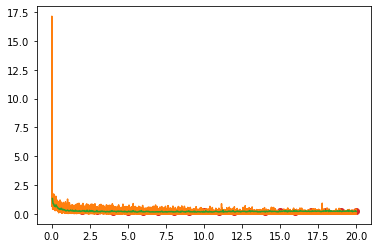

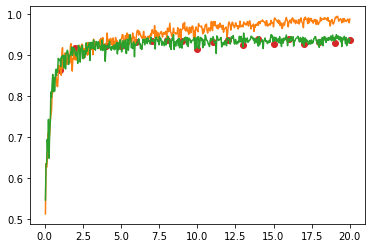

In [9]:
for epoch in range(num_epoch):
    train(epoch)
    test(epoch)
    test_counter = [(i + 1) for i in range(epoch + 1)]
    val_counter = []
    for j in range(epoch + 1):
        for i in range(25):
            val_counter.append(j + (i + 1)/25)

fig = plt.figure()
plt.plot(train_counter, train_losses, color='C1')
plt.plot(val_counter, val_losses, color='C2')
plt.scatter(np.array(test_counter), np.array(test_losses), color='C3')
fig
fig = plt.figure()
plt.plot(val_counter, train_acc, color='C1')
plt.plot(val_counter, val_acc, color='C2')
plt.scatter(np.array(test_counter), np.array(test_acc), color='C3')
fig
    
mat = np.array(test_acc) 
dataframe = pandas.DataFrame(mat)
dataframe.to_csv('./test_acc.csv',index=False,sep=',')

mat = np.array(train_acc) 
dataframe = pandas.DataFrame(mat)
dataframe.to_csv('./train_acc.csv',index=False,sep=',')

mat = np.array(val_acc) 
dataframe = pandas.DataFrame(mat)
dataframe.to_csv('./val_acc.csv',index=False,sep=',')

mat = np.array(test_losses) 
dataframe = pandas.DataFrame(mat)
dataframe.to_csv('./test_loss.csv',index=False,sep=',')

mat = np.array(test_counter) 
dataframe = pandas.DataFrame(mat)
dataframe.to_csv('./test_counter.csv',index=False,sep=',')   
 
mat = np.array(val_counter) 
dataframe = pandas.DataFrame(mat)
dataframe.to_csv('./val_counter.csv',index=False,sep=',')   
    
mat = np.array(val_losses) 
dataframe = pandas.DataFrame(mat)
dataframe.to_csv('./val_loss.csv',index=False,sep=',')   
             
mat = np.array(train_losses) 
dataframe = pandas.DataFrame(mat)
dataframe.to_csv('./train_loss.csv',index=False,sep=',')

mat = np.array(train_counter) 
dataframe = pandas.DataFrame(mat)
dataframe.to_csv('./train_counter.csv',index=False,sep=',') 

In [10]:
def val():
    print('start val')
    R.eval()
    label = []
    predict = []
    
    with torch.no_grad():
        for batch_idx, (_data,_label) in enumerate(val_loader):
            print(batch_idx)
            _data = _data.cuda()
            _label = _label.float()
            result = R(_data)
            result = result.cpu()
            for num in range(0,len(result)):
                predict.append(np.exp(result[num,:].numpy()))
                temp = np.zeros(4)
                temp[int(_label[num].numpy())] = 1
                label.append(temp)
        
    mat = np.array(label) 
    dataframe = pandas.DataFrame(mat)
    dataframe.to_csv('./label.csv',index=False,sep=',')
    
    mat = np.array(predict) 
    dataframe = pandas.DataFrame(mat)
    dataframe.to_csv('./predict.csv',index=False,sep=',')
    
    print('end val')

In [11]:
R.load_state_dict(torch.load('./resnet.pth'))
val()

start val
0
1
2
3
4
5
6
7
8
9
end val


In [12]:
from matplotlib.pyplot import MultipleLocator

In [13]:
def ReadData(path,_sep = ',',_type = np.float32):
    #读取数据
    data = pandas.read_csv(path,sep = _sep)
    npData = np.array(data).astype(_type)
    return npData

In [14]:
#读取数据
trainLoss = ReadData('train_loss.csv')
valLoss = ReadData('val_loss.csv')
testLoss = ReadData('test_loss.csv')
trainCounter = ReadData('train_counter.csv')
valCounter = ReadData('val_counter.csv')
testCounter = ReadData('test_counter.csv')
trainAcc = ReadData('train_acc.csv')
valAcc = ReadData('val_acc.csv')
testAcc = ReadData('test_acc.csv')

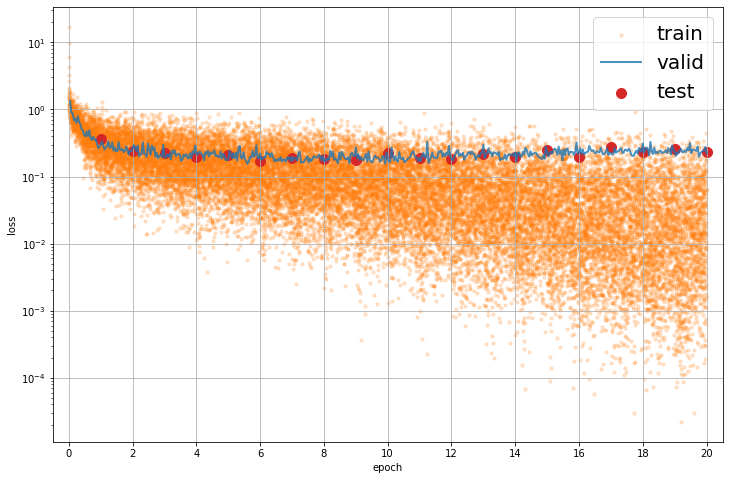

In [15]:
#绘制epoch-loss曲线
plt.figure(figsize=(12, 8))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xlim([-0.5,20.5])
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.grid(True)
plt.scatter(trainCounter, trainLoss,s=10,c = 'C1',alpha = 0.2, label="train")
plt.plot(valCounter, valLoss, 'C0-', lw=2,alpha = 0.8, label="valid")
plt.scatter(testCounter, testLoss,s=100,c = 'C3', label="test")
plt.yscale('log')
plt.legend(fontsize=20)
plt.savefig("loss.png")

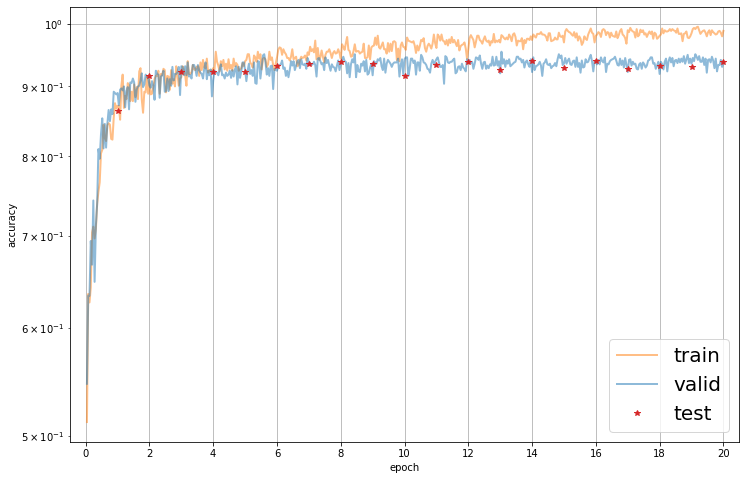

In [16]:
#绘制epoch-accuracy曲线
plt.figure(figsize=(12, 8))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim([-0.5,20.5])
#plt.ylim([0.35,1.02])
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.grid(True)
plt.plot(valCounter, trainAcc, 'C1-',alpha = 0.5, lw=2, label="train")
plt.plot(valCounter, valAcc, 'C0-', lw=2,alpha = 0.5, label="valid")
plt.plot(testCounter, testAcc, 'C3*', lw=4, label="test")
plt.yscale('log')
plt.legend(fontsize=20)
plt.savefig("accuracy.png")

In [17]:
#预设的数据格式每行为1个样本属于各个类别的概率[x1,x2,x3,x4]
trueLabels = ReadData('label.csv')
predLabels = ReadData('predict.csv')

In [18]:
def FPR(data,label,idx,threshold):
    #指定阈值的假阳性率
    count = 0
    goal = 0
    for i in range(len(data)):
        if label[i][idx] < 0.5:
            count += 1
            if data[i][idx] > threshold:
                goal += 1
    return goal / count

In [19]:
def TPR(data,label,idx,threshold):
    #指定阈值的真阳性率
    count = 0
    goal = 0
    for i in range(len(data)):
        if label[i][idx] > 0.5:
            count += 1
            if data[i][idx] > threshold:
                goal += 1
    return goal / count

In [20]:
n = 1000
fprs0 = [FPR(predLabels,trueLabels,0,i/n) for i in range(n)]
tprs0 = [TPR(predLabels,trueLabels,0,i/n) for i in range(n)]
fprs1 = [FPR(predLabels,trueLabels,1,i/n) for i in range(n)]
tprs1 = [TPR(predLabels,trueLabels,1,i/n) for i in range(n)]
fprs2 = [FPR(predLabels,trueLabels,2,i/n) for i in range(n)]
tprs2 = [TPR(predLabels,trueLabels,2,i/n) for i in range(n)]
fprs3 = [FPR(predLabels,trueLabels,3,i/n) for i in range(n)]
tprs3 = [TPR(predLabels,trueLabels,3,i/n) for i in range(n)]

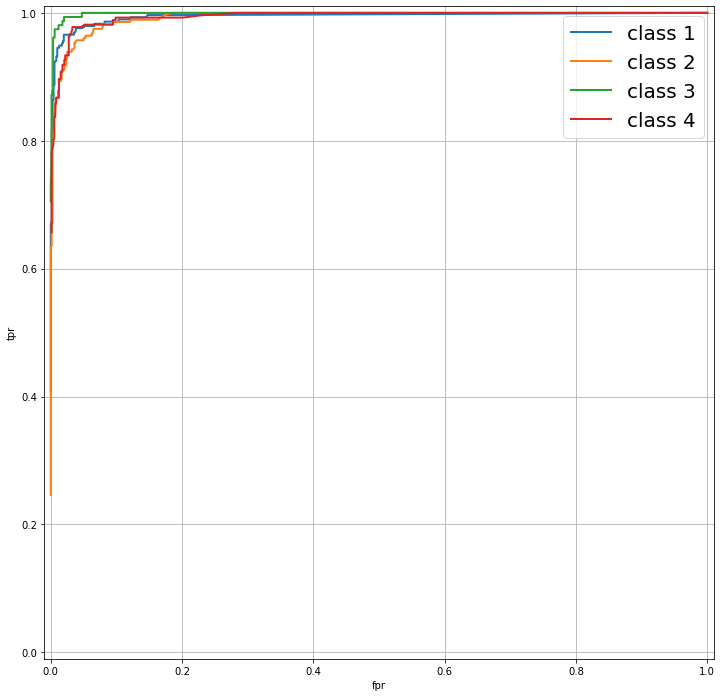

In [21]:
plt.figure(figsize=(12, 12))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
ax = plt.gca()
#ax.xaxis.set_major_locator(MultipleLocator(2))
ax.grid(True)
plt.plot(fprs0, tprs0, 'C0-', lw=2, label="class 1")
plt.plot(fprs1, tprs1, 'C1-', lw=2, label="class 2")
plt.plot(fprs2, tprs2, 'C2-', lw=2, label="class 3")
plt.plot(fprs3, tprs3, 'C3-', lw=2, label="class 4")
plt.legend(fontsize=20)
plt.savefig("ROC.png")

In [22]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [23]:
trueLabels = ReadData('label.csv')
predLabels = ReadData('predict.csv')
labels = ['1','2','3','4']
trueLabelsArray = []
predLabelsArray = []
for i in range(len(trueLabels)):
    trueLabelsArray.append(trueLabels[i].argmax())
    predLabelsArray.append(predLabels[i].argmax())

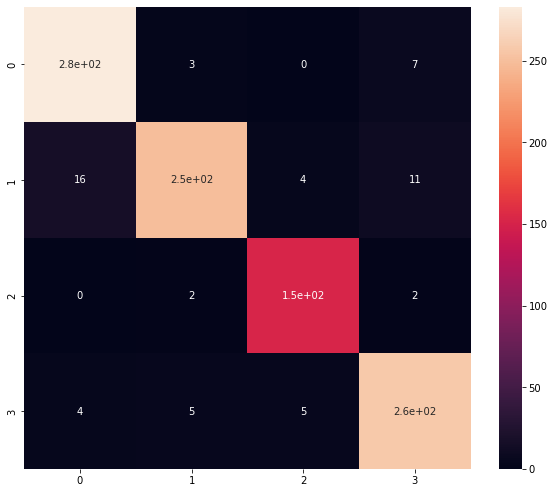

In [24]:
plt.figure(figsize = (10,8.5))
sns.heatmap(metrics.confusion_matrix(y_true=trueLabelsArray, y_pred=predLabelsArray), annot=True);
plt.savefig("ConfusionMatrix.png")

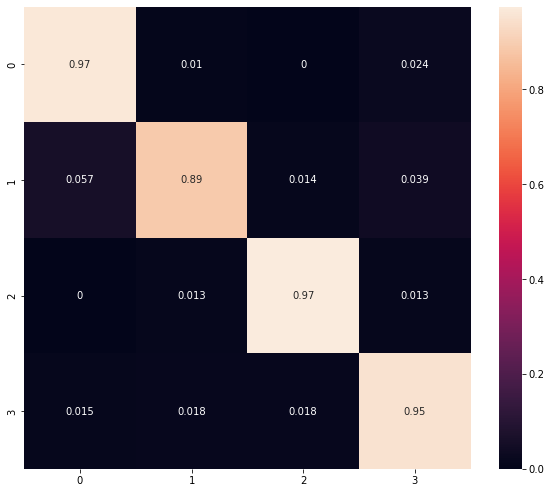

In [25]:
plt.figure(figsize = (10,8.5))
sns.heatmap(metrics.confusion_matrix(y_true=trueLabelsArray, y_pred=predLabelsArray,normalize = 'true'), annot=True)
plt.savefig("ConfusionMatrix%.png")